Lots to do, so we're gonna start with some basic pre-processing<br>
I'm not sure what else we need at this time other than tokenizing the tags you've generated<br>
I'll also take a look at how BERT might help us out.

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
# ^^ hugging face library for word embeddings
import sqlite3
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random
from keybert import KeyBERT

# print("howdy")

/home/acequantum/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ok so now I pull data from database<br>
I definitely remember how to do that

In [5]:
# Function for splitting camel case
# https://www.geeksforgeeks.org/python-split-camelcase-string-to-individual-strings/

def camel_case_split(str):
    return re.sub(r'([a-z])([A-Z])',
                      r'\1 \2', str)

In [6]:
# Connecting to Database
# If you're Ace
con = sqlite3.connect("/home/acequantum/playtime/dummy_data/1_dummy_data.db")
# If you're Sean
# con = sqlite3.connect("C:/Users/seana/OneDrive/Documents/Learning_Playground/Time_data.db")

# cur = con.cursor()

# for row in cur.execute('SELECT * FROM posts LIMIT 3;'):
    # print(row)

df = pd.read_sql_query("SELECT * FROM posts;", con)

# print(df.head())

df['new_tags'] = df['tags']

# print(df.head())

df['new_tags'] = df['tags'].apply(camel_case_split)

print(df.head())

# closing connection
con.close()

   id  user_id trade_status  \
0   1        1         None   
1   2        1         None   
2   3        2         None   
3   4        2         None   
4   5        2         None   

                                                tags  \
0     mangaAnimeMerch, diyTools, mechanicalKeyboards   
1  collectiblePins, petSittingDogWalking, vintage...   
2                             customToys, bakedGoods   
3     clayModelingKits, codingLessons, tattooDesigns   
4                 leatherGoods, bikeRepairs, watches   

                                                text  \
0  Really describe particularly whose opportunity...   
1  Analysis father board everybody. Car begin evi...   
2  Per assume community dog happy really stop. Ch...   
3  By song new know. Particularly third all inves...   
4  Three writer policy building. Offer the capita...   

                                            new_tags  
0  manga Anime Merch, diy Tools, mechanical Keybo...  
1  collectible Pins, pet Sitt

I'm at a toss up if I want to do a small bit of EDA and then use BERT to get us some more tags or if the deliminated data is enough to go forward with full EDA. I'll lyk.

In [7]:
# Splitting into a list of tags
# Because I forget that dataframes can handle lists as a field.
df['split_tags'] = df['new_tags'].str.split(', ')

# Boom Explosions
all_tags = df['split_tags'].explode()

unique_tags = all_tags.unique()
print("Unique tags:\n", unique_tags)
print(f"Number of unique tags: {unique_tags.size}")

Unique tags:
 ['manga Anime Merch' 'diy Tools' 'mechanical Keyboards' 'collectible Pins'
 'pet Sitting Dog Walking' 'vintage Clothing' 'custom Toys' 'baked Goods'
 'clay Modeling Kits' 'coding Lessons' 'tattoo Designs' 'leather Goods'
 'bike Repairs' 'watches' 'custom Stickers' 'exotic Spices'
 'graphic Design' 'gaming Consoles' 'vintage Vinyl Records'
 'gourmet Food Items' 'tailoring' 'art Prints Posters' 'graphic Novels'
 'handmade Soap' 'headphones' 'online Courses' 'rare Manuscripts'
 'artisanal Cheese' 'designer Handbags' 'camping Gear' 'books'
 'blu Rays Dvds' 'skateboards' 'embroidery Kits' 'antique Jewelry'
 'handyman Repairs' 'laptops' 'smartwatches' 'houseplants' 'web Design'
 'horror Memorabilia' 'fitness Trackers' 'candles Incense' 'surfboards'
 'tutoring' 'fresh Produce' 'VRHeadsets' 'mechanic Services'
 'snowboarding Gear' 'homemade Preserves' 'custom Art' 'computer Parts'
 'piano Lessons' 'local Honey' 'drones' 'comic Books' 'retro Toys'
 'storage Solutions' 'dslr Camera

The ratio of tags to posts that was just under 1:10, so I'll maybe see about generating a total of 2,000, but first we'll see what the similarities that we have is.

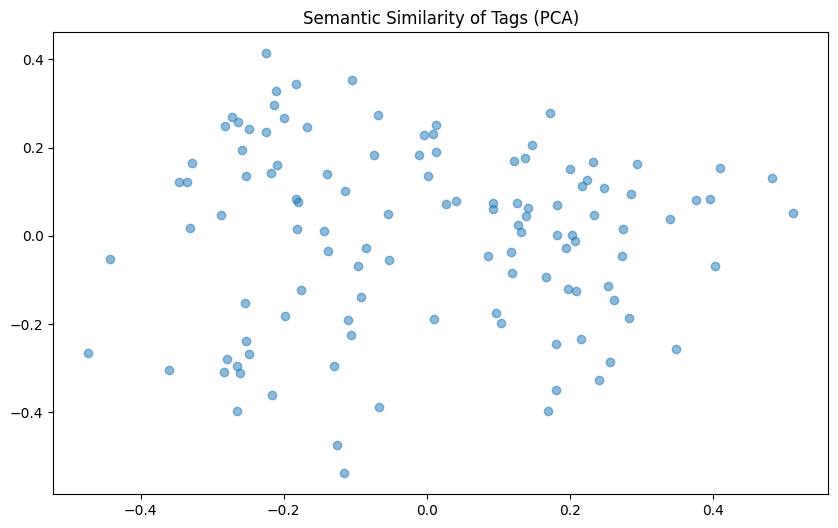

In [8]:
model = SentenceTransformer('all-miniLM-L6-v2')
tags = unique_tags

tag_embeddings = model.encode(tags)

# Reduction to human levels of understanding
pca = PCA(n_components=2)
tag_embeddings_2d = pca.fit_transform(tag_embeddings)

# Time to plot it!
plt.figure(figsize=(10, 6))
plt.scatter(tag_embeddings_2d[:, 0], tag_embeddings_2d[:, 1], alpha=0.5)

for i, tag in enumerate(tags):
    plt.Annotation(tag, (tag_embeddings_2d[i, 0], tag_embeddings_2d[i, 1]))

plt.title("Semantic Similarity of Tags (PCA)")
plt.show()

Well, that did not explain much. Maybe a heatmap?

In [ ]:
similarity_matrix = cosine_similarity(tag_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            xticklabels=tags,
            yticklabels=tags,
            annot=True, fmt=".2f")

plt.title("Pairwise Cosine Similarity")
plt.show

This did also not explain much.

In [9]:
# We're going to take some time to look at subsets.

# Looking at the most used tags
top_n = 20 #can be more if we want to look at more.
top_tags = pd.Series(all_tags).nlargest(top_n)

# Random Subset
subset_size = 15
randon_tags = random.sample(tags, subset_size)

# This is where we'd put category-based subsets 
# but that feels like a stretch


# None of this is going to be useful 
# except for telling us that our tags are in no way clustering

TypeError: Cannot use method 'nlargest' with dtype object

In [12]:
# Looks like we can use some BERT stuff again?
def get_similar_tags(seed_tag, tags, embeddings, top_k=5):
    seed_idx = tags.index(seed_tag)
    seed_embedding = embeddings[seed_idx].reshape(1, -1)
    similarities = cosine_similarity(seed_embedding, embeddings)[0]
    similar_indices = similarities.argsort()[-top_k-1:-1][::-1]
    return [tags[i] for i in similar_indices]

similar_to_bread = get_similar_tags("bread", unique_tags.tolist(), tag_embeddings)
similar_to_books = get_similar_tags("books", unique_tags.tolist(), tag_embeddings)

print(f"tags like books:\n{similar_to_books}")

tags like books:
['textbooks', 'comic Books', 'graphic Novels', 'video Games', 'piano Lessons']


Well, uh... we might need more tags with the help of BERT since he seems to think that of the unique 115 tags that we have, books and sneakers are among the closes relation to bread. I think we did fairly decent with baked goods and coffee means though.

In [ ]:
# https://huggingface.co/spaces/GT4SD/keyword_bert
kw_model = KeyBERT()
seed_tags = unique_tags.tolist()[:20]

full_list_of_tags = []

for tag in seed_tags:
    keywords = kw_model.extract_keywords(tag, keyphrase_ngram_range=(1,2))
    print(tag, keywords)

Well... it's not the best, but it's a bit better I guess?<br>
It's good enough to get us to the next step I guess.